In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pyscf import gto, scf, cc

In [ ]:
nh2 = 1
s = 20
e_hf = np.zeros(nh2)
e_ccsd = np.zeros(nh2)

def h2(d):
    h2 = f'''
    H 0 {d} 0
    H 1.058354498 {d} 0
    '''
    return h2

atoms = ''
for i in range(nh2):
    atoms += h2(i*s)

    mol = gto.M(atom=atoms, basis="sto6g", verbose=4)
    mf = scf.RHF(mol)
    mf.kernel()
    e_hf[i] = mf.e_tot

    mycc = cc.CCSD(mf)
    mycc.kernel()
    e_ccsd[i] = mycc.e_tot


System: uname_result(system='Linux', node='yichi-thinkpad', release='4.4.0-26100-Microsoft', version='#1882-Microsoft Fri Jan 01 08:00:00 PST 2016', machine='x86_64')  Threads 12
Python 3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:16:10) [GCC 13.3.0]
numpy 1.24.3  scipy 1.14.1  h5py 3.12.1
Date: Sun Jul  6 18:46:53 2025
PySCF version 2.8.0
PySCF path  /home/yichi/research/software/lno_pyscf
GIT HEAD (branch master) ef75f4190e4de208685670651dc6c467f72b6794

[ENV] PYSCF_EXT_PATH /home/yichi/research/software/pyscf
[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 2
[INPUT] num. electrons = 2
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 H      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.00

In [3]:
from ad_afqmc import run_afqmc, pyscf_interface
from mpi4py import MPI

MPI.Finalize()
pyscf_interface.prep_afqmc(mycc)

options = {
    "n_eql": 3,
    "n_ene_blocks": 1,
    "n_sr_blocks": 50,
    "n_blocks": 10,
    "n_walkers": 50,
    "seed": 98,
    "trial": "cisd",
    "walker_type": "rhf",
    "dt": 0.005,
}


run_afqmc.run_afqmc(options=options, nproc=8)

#
# Preparing AFQMC calculation
# If you import pyscf cc modules and use MPI for AFQMC in the same script, finalize MPI before calling the AFQMC driver.
# Calculating Cholesky integrals
# Finished calculating Cholesky integrals
#
# Size of the correlation space:
# Number of electrons: (1, 1)
# Number of basis functions: 2
# Number of Cholesky vectors: 3
#
# Hostname: yichi-thinkpad
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64
# Number of MPI ranks: 8
#
# norb: 2
# nelec: (1, 1)
#
# n_eql: 3
# n_ene_blocks: 1
# n_sr_blocks: 50
# n_blocks: 10
# n_walkers: 50
# seed: 98
# trial: cisd
# walker_type: rhf
# dt: 0.01
# n_exp_terms: 6
# n_prop_steps: 50
# orbital_rotation: True
# do_sr: True
# symmetry: False
# save_walkers: False
# ene0: 0.0
# free_projection: False
# n_batch: 1
# LNO: False
# orbE: 0
# maxError: 0.001
#
# Equilibration sweeps:
#   Iter        Block energy      Walltime
#     0      -1.096071266e+00     8.18e+00 
#     1      -1.096071362e+00     2.52e+01 


(-1.0960712432861328, 0.0)

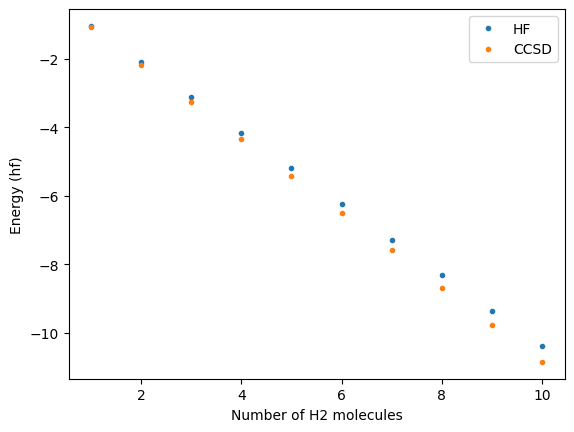

In [23]:
from matplotlib import pyplot as plt
plt.plot(np.arange(1,nh2+1),e_hf,'.', label='HF')
plt.plot(np.arange(1,nh2+1),e_ccsd,'.', label='CCSD')
plt.xlabel('Number of H2 molecules')
plt.ylabel('Energy (hf)')
plt.legend()
plt.show()

In [24]:
print('HF energy per molecule',e_hf/np.arange(1,nh2+1))
print('CCSD energy per molecule',e_ccsd/np.arange(1,nh2+1))

HF energy per molecule [-1.03917824 -1.03917834 -1.03917839 -1.03917842 -1.03917845 -1.03917846
 -1.03917848 -1.03917849 -1.0391785  -1.03917851]
CCSD energy per molecule [-1.08433744 -1.08433751 -1.08433754 -1.08433756 -1.08433757 -1.08433759
 -1.0843376  -1.0843376  -1.08433761 -1.08433762]


In [4]:
n_h2 = np.array([1,20,40,60,80,100])
e_lno_afqmc = np.array([-0.039584,-0.791837,-1.583531,-2.375420,-3.167147,-3.959048])
err =np.array([0.000004,0.000018,0.000025,0.000031,0.000036,0.000040])
e_per_mol = e_lno_afqmc/n_h2
err_per_mol = err/np.sqrt(n_h2)
np.set_printoptions(precision=6, suppress=True)
print(e_per_mol)
print(err_per_mol)

[-0.039584 -0.039592 -0.039588 -0.03959  -0.039589 -0.03959 ]
[0.000004 0.000004 0.000004 0.000004 0.000004 0.000004]


In [14]:
# afqmc/ccsd
e_hf = np.array([-1.05642985919892,-21.1630864567903,-42.3261730715115,
                 -63.4892597405876,-84.6523464437062,-105.81543317154])
e_afqmc = np.array([-1.09607,-21.909,-43.810,-65.709,-87.595,-109.487])
afqmc_err =np.array([0.00000,0.001,0.002,0.004,0.006,0.006])
afqmc_corr_per_mol = (e_afqmc-e_hf)/n_h2
afqmc_err_per_mol = afqmc_err/np.sqrt(n_h2)
np.set_printoptions(precision=6, suppress=True)
print(afqmc_corr_per_mol)
print(afqmc_err_per_mol)

[-0.03964  -0.037296 -0.037096 -0.036996 -0.036783 -0.036716]
[0.       0.000224 0.000316 0.000516 0.000671 0.0006  ]


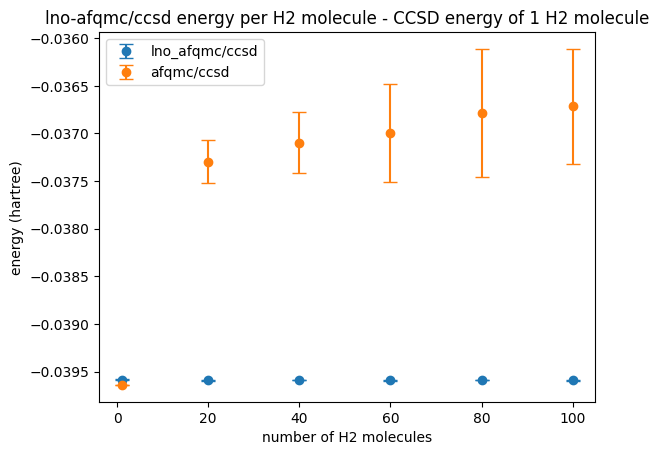

In [ ]:
# x = np.linspace(max(n_h2),min(n_h2),100)
# plt.plot(x,np.array([e_afqmc_corr-e_ccsd_corr]*100),color='black', linestyle='--')
# plt.fill_between(x, np.array([e_afqmc_corr-e_ccsd_corr]*100) + err_afqmc, 
#                  np.array([e_afqmc_corr-e_ccsd_corr]*100) - err_afqmc, 
#                  color='blue', alpha=0.4,label='afqmc/ccsd at N=100')
plt.errorbar(n_h2,e_per_mol,yerr=err_per_mol,fmt='o',capsize=5,label='lno_afqmc/ccsd')
plt.errorbar(n_h2,afqmc_corr_per_mol,yerr=afqmc_err_per_mol,fmt='o',capsize=5,label='afqmc/ccsd')
plt.xlabel('number of H2 molecules')
plt.ylabel('energy (hartree)')
plt.title('correlation energy per H2 molecule')
plt.legend()
plt.show()